In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
np.warnings.filterwarnings('ignore')

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras import models, layers
from keras.optimizers import SGD

#from keras.layers import Dropout

from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score,\
                            roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
#from sklearn.ensemble import BaggingClassifier
sns.set()

df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

## Preprocesado

In [2]:
# Tengo que recargar el archivo para que tome los cambios que se hicieron en el mismo

import importlib, sys

#importlib.reload(sys.modules['Preprocessing'])
from Preprocessing import *

In [3]:
df = preprod_tp1(df_data, df_decision)
df = replace_nulls_edad(df, 'media')
df.head()

,tipo_de_sala,id_usuario,genero,edad,amigos,parientes,precio_ticket,nombre_sede,cant_acompañantes,volveria
0,4d,117,hombre,73.5,0,0,1,fiumark_quilmes,0,0
1,4d,658,mujer,35.0,1,1,2,fiumark_quilmes,2,0
2,normal,794,hombre,32.7,0,0,3,fiumark_chacarita,0,0
3,4d,455,hombre,32.7,0,0,1,fiumark_palermo,0,0
4,4d,173,mujer,4.0,1,1,2,fiumark_palermo,2,1


In [4]:
df = normalizar_atributos_numericos(df)
df.head()

,tipo_de_sala,id_usuario,genero,edad,amigos,parientes,precio_ticket,nombre_sede,cant_acompañantes,volveria
0,4d,0.130337,hombre,0.880653,0.000,0.000000,0.000000,fiumark_quilmes,0.0,0.0
1,4d,0.738202,mujer,0.396985,0.125,0.166667,0.020408,fiumark_quilmes,0.2,0.0
2,normal,0.891011,hombre,0.368090,0.000,0.000000,0.040816,fiumark_chacarita,0.0,0.0
3,4d,0.510112,hombre,0.368090,0.000,0.000000,0.000000,fiumark_palermo,0.0,0.0
4,4d,0.193258,mujer,0.007538,0.125,0.166667,0.020408,fiumark_palermo,0.2,1.0


In [5]:
df = encodear_atributos_categoricos(df)
df.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes,volveria
0,0,0,1,0.130337,0,1,0.880653,0.000,0.000000,0.000000,0,0,1,0.0,0.0
1,0,0,1,0.738202,1,0,0.396985,0.125,0.166667,0.020408,0,0,1,0.2,0.0
2,0,1,0,0.891011,0,1,0.368090,0.000,0.000000,0.040816,0,1,0,0.0,0.0
3,0,0,1,0.510112,0,1,0.368090,0.000,0.000000,0.000000,0,1,1,0.0,0.0
4,0,0,1,0.193258,1,0,0.007538,0.125,0.166667,0.020408,0,1,1,0.2,1.0


# Entrenamiento

In [6]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]

In [7]:
X.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes
0,0,0,1,0.130337,0,1,0.880653,0.000,0.000000,0.000000,0,0,1,0.0
1,0,0,1,0.738202,1,0,0.396985,0.125,0.166667,0.020408,0,0,1,0.2
2,0,1,0,0.891011,0,1,0.368090,0.000,0.000000,0.040816,0,1,0,0.0
3,0,0,1,0.510112,0,1,0.368090,0.000,0.000000,0.000000,0,1,1,0.0
4,0,0,1,0.193258,1,0,0.007538,0.125,0.166667,0.020408,0,1,1,0.2


In [8]:
n_features = X.columns.size

In [9]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: volveria, dtype: float64

In [10]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

In [17]:
from keras import metrics

In [18]:
def generadorRed(n_nuronas=32, n_capas_intermedias=4, lr=0.2):
    
    red = models.Sequential()

    red.add(layers.Dense(units=n_nuronas, activation='relu', input_shape=(n_features, )))
    
    for _ in range(n_capas_intermedias):
        red.add(layers.Dense(units=n_nuronas, activation='relu'))


    red.add(layers.Dense(units=1, activation='sigmoid'))

    # Compile neural network
    red.compile(loss='binary_crossentropy',  # Binary Cross Entropy, for Classification 
                optimizer=SGD(lr=lr),  # Stocastic Gradiend Descent
                metrics=[metrics.AUC()])  # Accuracy performance metric TODO VER si hay mejores metricas
    return red

In [19]:
cantidad_folds = 5

# lr => learning rate
# n_nuronas => cantidad de neuronas
# n_capas_intermedias => cantidad de capas

params = {'lr': [0.1, 0.2, 0.4, 0.7],\
          'n_nuronas': [4, 8, 16, 32],\
         'n_capas_intermedias': [1, 2, 4, 8, 16] }

red_neuronal = KerasClassifier(build_fn=generadorRed,
                              epochs=2000,
                              batch_size=X_train.shape[0],
                              verbose=0)

#red_neuronal.add(Dropout(0.25))

rgscv = RandomizedSearchCV(
    red_neuronal,
    params, n_iter=60, scoring='roc_auc', 
    cv=cantidad_folds, return_train_score=True
).fit(X_train, y_train)

In [21]:
print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: 0.8657259982835983
Best params {'n_nuronas': 8, 'n_capas_intermedias': 2, 'lr': 0.1}


## Evaluacion

In [23]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [24]:
def mi_loss(y_test, X_test):
    val = roc_auc_score(y_test, rgscv.predict_proba(X_test)[:,1])
    if val > 0.5:
        val = 1 - val
    return val

In [25]:
loss = mi_loss(y_test, X_test)
es = EarlyStopping(monitor=loss, mode='min')

In [26]:
hist = red_neuronal.fit(
    X_train, 
    y_train,
    epochs=2000,
    verbose=2,
    callbacks=[es],
    validation_data=(X_test, np.array(y_test)),)

Epoch 1/2000
1/1 - 1s - loss: 0.7034 - auc_301: 0.6498 - val_loss: 0.6965 - val_auc_301: 0.7136
Epoch 2/2000
1/1 - 0s - loss: 0.6937 - auc_301: 0.7255 - val_loss: 0.6884 - val_auc_301: 0.7283
Epoch 3/2000
1/1 - 0s - loss: 0.6879 - auc_301: 0.7449 - val_loss: 0.6819 - val_auc_301: 0.7292
Epoch 4/2000
1/1 - 0s - loss: 0.6834 - auc_301: 0.7540 - val_loss: 0.6764 - val_auc_301: 0.7696
Epoch 5/2000
1/1 - 0s - loss: 0.6796 - auc_301: 0.7573 - val_loss: 0.6718 - val_auc_301: 0.7421
Epoch 6/2000
1/1 - 0s - loss: 0.6765 - auc_301: 0.7678 - val_loss: 0.6678 - val_auc_301: 0.7575
Epoch 7/2000
1/1 - 0s - loss: 0.6737 - auc_301: 0.7780 - val_loss: 0.6640 - val_auc_301: 0.7804
Epoch 8/2000
1/1 - 0s - loss: 0.6710 - auc_301: 0.7860 - val_loss: 0.6601 - val_auc_301: 0.7653
Epoch 9/2000
1/1 - 0s - loss: 0.6681 - auc_301: 0.7895 - val_loss: 0.6563 - val_auc_301: 0.7555
Epoch 10/2000
1/1 - 0s - loss: 0.6652 - auc_301: 0.7964 - val_loss: 0.6528 - val_auc_301: 0.7704
Epoch 11/2000
1/1 - 0s - loss: 0.6625 -

In [27]:
# TODO: arreglar este grafico

fig = plt.figure(figsize=(12, 6), dpi=100)
plt.plot(hist.history["val_accuracy"], label="validation accuracy")
plt.plot(hist.history["accuracy"], label="training accuracy")
plt.xlabel("Epoch", weight="bold", fontsize=16)
plt.ylabel("Accuracy", weight="bold", fontsize=16)
plt.legend()

KeyError: 'val_accuracy'

<Figure size 1200x600 with 0 Axes>

## Metricas

### AUC ROC

In [35]:
roc = roc_auc_score(y_test, rgscv.predict_proba(X_test)[:,1])
print(f"{roc:.4f}")

0.8362


### Accuracy

In [36]:
acc = accuracy_score(y_test, rgscv.predict(X_test))
print(f"{acc:.4f}")

0.7950


### Precision

In [37]:
precision = precision_score(y_test, rgscv.predict(X_test))
print(f"{precision:.4f}")

0.7500


### Recall

In [38]:
recall = recall_score(y_test, rgscv.predict(X_test), pos_label=0)
print(f"{recall:.4f}")

0.8962


### F1-Score

In [39]:
f1 = f1_score(y_test, rgscv.predict(X_test))
print(f"{f1:.4f}")

0.6667


### Matriz de confusion

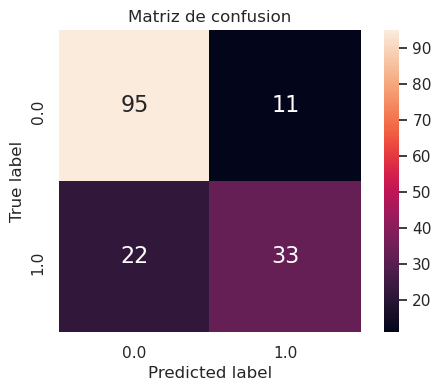

In [32]:
def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusion")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


plot_confusion_matrix(y_test, rgscv.predict(X_test))

## Test Holdout

In [40]:
holdout = pd.read_csv('https://drive.google.com/uc?export=download&id=1I980-_K9iOucJO26SG5_M8RELOQ5VB6A')
holdout.head(5)

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señorita Beatriz Estela,650,mujer,26.0,0,0,"EC0""4536",1,NaN,fiumark_palermo
1,4d,Señorita Elena Herminda,234,mujer,8.0,4,2,569299,4,NaN,fiumark_palermo
2,normal,Señor Humberto Americo,31,hombre,43.0,0,0,"RE""39823",3,NaN,fiumark_chacarita
3,3d,Señor Casiano,552,hombre,30.0,0,0,46657:,3,NaN,fiumark_palermo
4,4d,Señor Gregorio Nicolas,411,hombre,NaN,0,0,56;444,1,NaN,fiumark_palermo


In [41]:
df_h = prepod_tp1_un_df(holdout)
df_h = replace_nulls_edad(df_h, 'media')
df_h = normalizar_atributos_numericos(df_h)
df_h = encodear_atributos_categoricos(df_h)
df_h = df_h.drop(['volveria'], axis=1)
df_h.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes
0,0,0,1,0.751756,0,1,0.344774,0.0,0.0,0.000000,0,0,1,0.0
1,0,0,1,0.264637,0,1,0.063963,0.5,0.4,0.061224,0,0,1,0.6
2,0,1,0,0.026932,1,0,0.609984,0.0,0.0,0.040816,0,1,0,0.0
3,0,1,1,0.637002,1,0,0.407176,0.0,0.0,0.040816,0,0,1,0.0
4,0,0,1,0.471897,1,0,0.450858,0.0,0.0,0.000000,0,0,1,0.0


In [45]:
y_pred = rgscv.predict(df_h)
y_pred = y_pred.astype(int)
y_pred

array([[0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
    

In [54]:
variable = []
for j in y_pred:
    variable.append(j[0])

In [57]:
serie_predicha = pd.Series(variable, name='volveria') 
serie_predicha = serie_predicha.to_frame()
serie_predicha.head(15)

,volveria
0,0
1,0
2,1
3,1
4,1
5,1
6,0
7,1
8,1
9,0


In [58]:
df_predicho = holdout.join(serie_predicha, how='inner')
cols = ['id_usuario', 'volveria']
df_resultado = df_predicho[cols]
df_resultado.head()

,id_usuario,volveria
0,650,0
1,234,0
2,31,1
3,552,1
4,411,1


In [59]:
df_resultado.shape

(90, 2)

In [60]:
df_resultado.to_csv('prediccion/red_neuronal_resultado_final.csv')